**Author:** Matt Sarmiento

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datasets" data-toc-modified-id="Datasets-1">Datasets</a></span></li><li><span><a href="#Data-Clean" data-toc-modified-id="Data-Clean-2">Data Clean</a></span><ul class="toc-item"><li><span><a href="#EU-Deaths-1995-2017" data-toc-modified-id="EU-Deaths-1995-2017-2.1">EU Deaths 1995-2017</a></span><ul class="toc-item"><li><span><a href="#Split-Data-by-Year" data-toc-modified-id="Split-Data-by-Year-2.1.1">Split Data by Year</a></span></li></ul></li><li><span><a href="#EU-Population-2015-2017" data-toc-modified-id="EU-Population-2015-2017-2.2">EU Population 2015-2017</a></span><ul class="toc-item"><li><span><a href="#2017" data-toc-modified-id="2017-2.2.1">2017</a></span></li><li><span><a href="#2016" data-toc-modified-id="2016-2.2.2">2016</a></span></li><li><span><a href="#2015" data-toc-modified-id="2015-2.2.3">2015</a></span></li></ul></li><li><span><a href="#Join" data-toc-modified-id="Join-2.3">Join</a></span></li><li><span><a href="#Deaths-per-1-Million" data-toc-modified-id="Deaths-per-1-Million-2.4">Deaths per 1 Million</a></span></li><li><span><a href="#U.S.-Deaths-2017" data-toc-modified-id="U.S.-Deaths-2017-2.5">U.S. Deaths 2017</a></span></li><li><span><a href="#Concat" data-toc-modified-id="Concat-2.6">Concat</a></span></li></ul></li><li><span><a href="#Drop" data-toc-modified-id="Drop-3">Drop</a></span></li><li><span><a href="#Portugal-Plot" data-toc-modified-id="Portugal-Plot-4">Portugal Plot</a></span></li></ul></div>

In [1]:
# Third-party imports
import numpy as np
import pandas as pd

In [2]:
# Load rpy2 extension (may need to re-run)
%reload_ext rpy2.ipython

In [3]:
# Load R libraries
%R library(ggplot2)
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

----------------

# Datasets

We want to compare the incidence of drug-induced deaths among the major EU countries with that of the U.S.. Specifically, we want to know what the drug-induced death rate is per million citizens in each country. For this we need the following datasets:

1. `EU-overdoses-1995-2017`, which contains drug-induced death counts for **ages 16-54** per country.
2. `EU-pop-2017`, which contains population counts for **ages 16-54** per EU country in 2017
3. `EU-pop-2016`, which contains population counts for **ages 16-54** per EU country in 2016
4. `EU-pop-2015`, which contains population counts for **ages 16-54** per EU country in 2015
5. `deaths-ages-15-64-2017`, which contains drug-induced death rates for **ages 16-54** in the U.S in 2017

Once we've cleaned them up, we'll produce a dataset for the drug-induced death rate per E.U. country.

----------------

# Data Clean


## EU Deaths 1995-2017

First, let's take a look at we have. 

**Update:** After inspecting our dataset, we've re-loaded it with the correct row set as the header.

In [4]:
# Load data with correct row as header
EU = pd.read_csv('../input/EU-overdoses-1995-2017.csv', header=3)
EU.head(3)

,Country,2017,2016,2015,2014,2013,2012,2011,2010,2009,...,2003,2002,2001,2000,1999,1998,1997,1996,1995,Unnamed: 24
0,Austria *,107.0,122.0,150.0,139.0,194.0,221.0,237.0,207.0,223.0,...,192.0,84.0,153.0,167.0,135.0,119.0,NaN,NaN,NaN,NaN
1,Belgium,NaN,NaN,NaN,61.0,74.0,72.0,94.0,106.0,155.0,...,97.0,NaN,NaN,NaN,113.0,48.0,123.0,137.0,132.0,NaN
2,Bulgaria,18.0,22.0,17.0,15.0,21.0,24.0,25.0,41.0,38.0,...,15.0,13.0,24.0,41.0,28.0,21.0,16.0,11.0,19.0,NaN


### Split Data by Year

Since not all countries have reported overdose counts for 2017, we will split our data frame into three:
1. Countries with counts for 2017
2. Countries with counts for 2016 (but not 2017)
3. Countries with counts for 2015 (but not 2016-17)

Moreover, for each dataset we'll
* Keep only the Country and Year columns
* Rename the Year column to "Deaths"
* **Update:** Annoyingly, certain countries have asterisks `*` next to them to mark footnotes, e.g. `Austria *`. We need to strip these asterisks in order to join on Country name later on.

In [5]:
# 2017
EU2017 = EU.loc[EU['2017'].isna() == False]
EU2017 = EU2017[['Country', '2017']]
EU2017.columns = ['Country', 'Deaths']
EU2017['Country'] = EU2017.Country.apply(lambda name: name.rstrip(' *'))

# 2016
EU2016 = (EU.loc[(EU['2016'].isna() == False) & 
                 (EU['2017'].isna() == True)])
EU2016 = EU2016[['Country', '2016']]
EU2016.columns = ['Country', 'Deaths']
EU2016['Country'] = EU2016.Country.apply(lambda name: name.rstrip(' *'))

# 2015
EU2015 = (EU.loc[(EU['2015'].isna() == False) &
                 (EU['2016'].isna() == True) &
                 (EU['2017'].isna() == True)])
EU2015 = EU2015[['Country', '2015']]
EU2015.columns = ['Country', 'Deaths']
EU2015['Country'] = EU2015.Country.apply(lambda name: name.rstrip(' *'))

EU2017.head(3)

,Country,Deaths
0,Austria,107.0
2,Bulgaria,18.0
3,Croatia,65.0


## EU Population 2015-2017

We need to tidy things up so that we can join our population datasets with our overdose count datasets. Specifically, for each dataset we need to:
1. Rename the "Country Code" column to "Country" (which is the column we'll join on)
2. Rename the population code column to "Population" 
3. Add a column for Year (for bookkeeping purposes)


### 2017

In [6]:
# Load data
pop2017 = pd.read_csv('../input/EU-pop-2017.csv')
pop2017.head(3)

,Series Name,Series Code,Country Name,Country Code,2017 [YR2017]
0,"Population ages 15-64, total",SP.POP.1564.TO,Sweden,SWE,6287411.0
1,"Population ages 15-64, total",SP.POP.1564.TO,Netherlands,NLD,11110457.0
2,"Population ages 15-64, total",SP.POP.1564.TO,Finland,FIN,3440986.0


In [7]:
# Select cols we want
pop2017 = pop2017[['Country Name', '2017 [YR2017]']]

# Rename cols
pop2017.columns = ["Country", "Pop"]

# Add col for year
pop2017['Year'] = 2017
pop2017.head(3)

,Country,Pop,Year
0,Sweden,6287411.0,2017
1,Netherlands,11110457.0,2017
2,Finland,3440986.0,2017


### 2016

In [8]:
# Load data
pop2016 = pd.read_csv('../input/EU-pop-2016.csv')
pop2016.head(3)

,Series Name,Series Code,Country Name,Country Code,2016 [YR2016]
0,"Population ages 15-64, total",SP.POP.1564.TO,United Kingdom,GBR,42146414.0
1,"Population ages 15-64, total",SP.POP.1564.TO,Norway,NOR,3434052.0
2,"Population ages 15-64, total",SP.POP.1564.TO,Denmark,DNK,3664797.0


In [9]:
# Select cols we want
pop2016 = pop2016[['Country Name', '2016 [YR2016]']]

# Rename cols
pop2016.columns = ["Country", "Pop"]

# Add col for year
pop2016['Year'] = 2016

### 2015

In [10]:
# Load data
pop2015 = pd.read_csv('../input/EU-pop-2015.csv')
pop2015.head(1)

,Series Name,Series Code,Country Name,Country Code,2015 [YR2015]
0,"Population ages 15-64, total",SP.POP.1564.TO,France,FRA,41798307.0


In [11]:
# Select cols we want
pop2015 = pop2015[['Country Name', '2015 [YR2015]']]

# Rename cols
pop2015.columns = ["Country", "Pop"]

# Add col for year
pop2015['Year'] = 2015
pop2015.head(3)

,Country,Pop,Year
0,France,41798307.0,2015
1,Italy,39071616.0,2015
2,Germany,53557394.0,2015


## Join

Now we'll merge each dataset `EU20##` with its corresponding population dataset `pop20##`, to get a grand total of three datasets:
* `EU2017`
* `EU2016`
* `EU2015`

In [12]:
# 2017 merge
EU2017 = EU2017.merge(pop2017, on="Country")

# 2016 merge
EU2016 = EU2016.merge(pop2016, on="Country")

# 2015 merge
EU2015 = EU2015.merge(pop2015, on="Country")
EU2015.head(3)

,Country,Deaths,Pop,Year
0,France,373.0,41798307.0,2015
1,Germany,1306.0,53557394.0,2015
2,Italy,251.0,39071616.0,2015


In [13]:
EU2016

,Country,Deaths,Pop,Year
0,Denmark,237.0,3664797.0,2016
1,Norway,282.0,3434052.0,2016
2,Portugal,30.0,6707573.0,2016
3,Spain,154.0,30829794.0,2016
4,United Kingdom,3256.0,42146414.0,2016


## Deaths per 1 Million

We're nearly there. The last thing left to do is to get the overdose rate per 1 million for each country. For each dataset we need to:
1. Convert the Population units to millions
2. Divide the Overdose count by the Population (in millions) to get the overdose death rate.

We've also decided to round rates to the nearest integer, for ease of interpretation (e.g. 8 deaths per 1 million instead of 8.3 deaths per 1 million)

In [14]:
# 2017
EU2017['Pop (millions)'] = EU2017['Pop'] / 1_000_000
EU2017['Rate'] =  np.round(EU2017['Deaths'] / EU2017['Pop (millions)'], 0)

# 2016
EU2016['Pop (millions)'] = EU2016['Pop'] / 1_000_000
EU2016['Rate'] =  np.round(EU2016['Deaths'] / EU2016['Pop (millions)'], 0)

# 2015
EU2015['Pop (millions)'] = EU2015['Pop'] / 1_000_000
EU2015['Rate'] =  np.round(EU2015['Deaths'] / EU2015['Pop (millions)'], 0)

EU2015.head(3)

,Country,Deaths,Pop,Year,Pop (millions),Rate
0,France,373.0,41798307.0,2015,41.798307,9.0
1,Germany,1306.0,53557394.0,2015,53.557394,24.0
2,Italy,251.0,39071616.0,2015,39.071616,6.0


## U.S. Deaths 2017

To concatenate our US dataset with our EU datasets, we need to:
1. Add a "Country" column
2. Convert the Crude Rate from deaths per 100,000 (default) to deaths per 1 million.
3. Rename the "Crude Rate" column to "Rate" 


In [15]:
# Load data
US2017 = pd.read_csv('../input/deaths-ages-15-64-2017.csv', sep='\t')
US2017.head(1)

,Notes,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,2017.0,2017.0,66547.0,213838947.0,31.1,31.6


In [16]:
# Add Country col
US2017['Country'] = "United States"

# Convert units for crude rate
US2017['Crude Rate'] = US2017['Crude Rate'] * 10

# Rename cols
US2017 = US2017.rename(columns={'Crude Rate': 'Rate'})

# Keep only 1st row
US2017 = US2017.iloc[0:1]
US2017

,Notes,Year,Year Code,Deaths,Population,Rate,Age Adjusted Rate,Country
0,NaN,2017.0,2017.0,66547.0,213838947.0,311.0,31.6,United States


## Concat

For ease of plotting in `ggplot`, we will:
1. Concatenate our three `EU20##` datasets with our `US2017` dataset
2. Sort countries by increasing death rate
3. Convert "Country" to a categorical variable (so the sort order is preserved in ggplot)

In [17]:
# Concatenate
US_EU = pd.concat([US2017, EU2017, EU2016, EU2015], sort=False) 

# Select cols we want
US_EU = US_EU[['Country', 'Year', 'Deaths', 'Rate']]

# Sort by increasing death rate
# Note: We sort by year to get Portugal before Bulgaria ;)
US_EU = US_EU.sort_values(by=["Rate", "Year"], ascending=False).reset_index(drop=True)

# Casts country to categorical type (to fix the order)
US_EU['Country'] = pd.Categorical(US_EU.Country, categories=US_EU.Country)
US_EU.head(3)

,Country,Year,Deaths,Rate
0,United States,2017.0,66547.0,311.0
1,Estonia,2017.0,110.0,130.0
2,Sweden,2017.0,626.0,100.0


# Drop 

We have 20 countries, which we feel is a bit too many to plot in one visual. We need to drop a handful of countries. We've decided to drop all Eastern European countries:

* Bulgaria 
* Latvia
* Slovenia
* Lithuania
* Estonia

**Reasoning:** In comparing U.S. and Portugal our focus has been inherently Western-centric all along. Also, by only looking at data from 2015-2017, we have already left out a significant number of European countries (e.g. Greece, Poland, Romania, Turkey, etc.), and we don't believe there's any harm in leaving out a few more (though we admit our choice is somewhat arbitrary).


In [18]:
# Arbitrary countries to exclude
exclude = ['Bulgaria', 'Latvia', 'Slovenia', 'Lithuania', 'Estonia']

# Drop countries
US_EU = US_EU.loc[US_EU.Country.isin(exclude) == False]
US_EU.tail(3)

,Country,Year,Deaths,Rate
16,Italy,2015.0,251.0,6.0
17,Spain,2016.0,154.0,5.0
19,Portugal,2016.0,30.0,4.0


-----------

# Portugal Plot

We'll plot a horizontal bar chart with Countries on the y-axis and deaths on the x-axis.

TODO:
* Add annotation in white space to give some context
* Left-align caption at bottom
* Last: Left-align title & subtitle using hjust (there must be a better way to do this)

In [19]:
# Push dataframe to R
%R -i US_EU

In [20]:
%%R

# Number of countries
n = length(US_EU$Country)

# Theme vars
faces <- c("bold", rep("plain", n-2), "bold")
colours <- c("Black", rep("grey30", n-2), "Black")


# Custom theme
theme_custom <- theme(text = element_text(family = "Helvetica"),
                      panel.grid = element_blank(),
                      plot.margin = unit(c(0.5, 2, 1.5, 0.5), "cm"),
                      plot.title = element_text(size = 24, face = "plain", hjust = 0.28, vjust = 2),
                      plot.subtitle = element_text(size = 18, colour = "grey30", hjust = 0.025, vjust = 1.7),
                      plot.caption = element_text(size = 12, colour = "grey60", hjust = 0, vjust = -2),
                      axis.title = element_blank(),
                      axis.text.x = element_blank(),
                      axis.text.y = element_text(size = 13, colour = colours, face = faces))

# Bar vars
highlight <- "firebrick4"
normal <- "#F2EAD0"
bar_fill <- c(highlight, rep(normal, n-2), highlight)

# Annotation vars
counts <- US_EU$Rate
acolours <- c("white", rep("grey40", n-2), "black")
x1 <- US_EU$Country
y1 <- c(counts[1:10] - 7, counts[11:15] + 3.2)

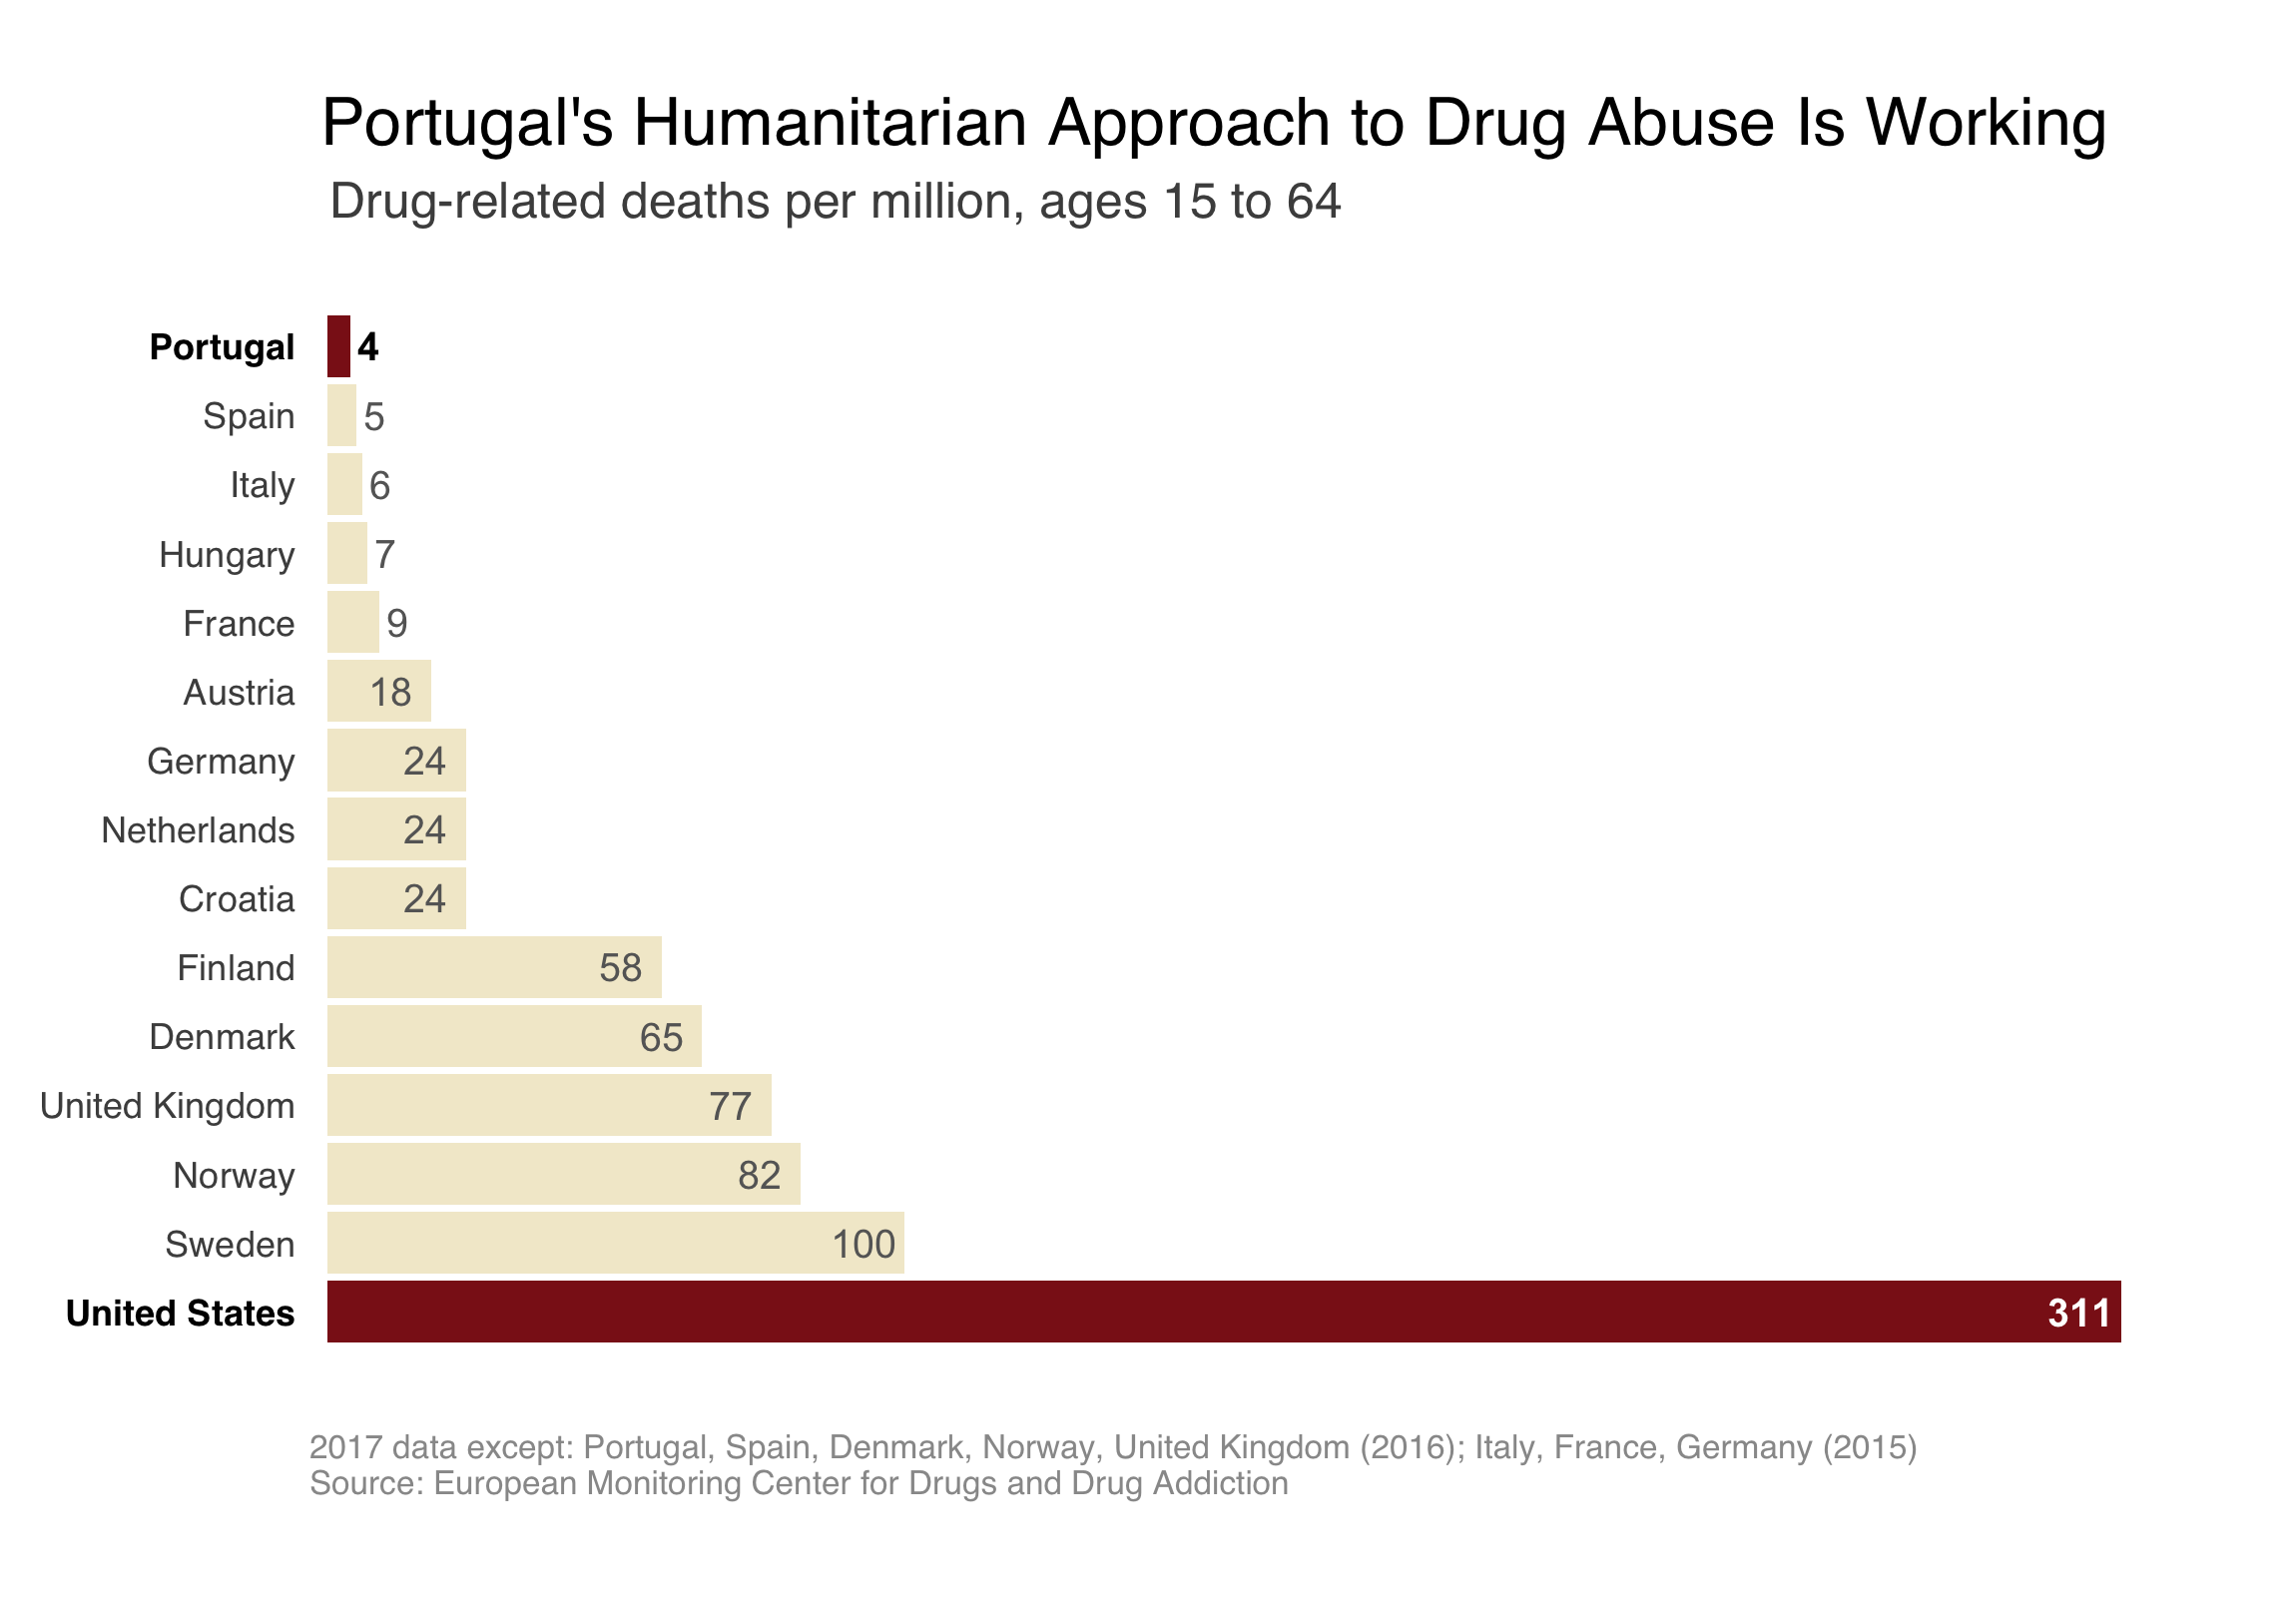

In [21]:
%%R -h 8 -w 11.5 -u in -r 200

# Base
q <- ggplot(data = US_EU, aes(x = Country, y = Rate))

# Geoms
q <- q + geom_col(fill = bar_fill)

# Axes
q <- q + scale_y_continuous(expand=c(0.01, 0))

# Annotations
q <- q + annotate("text", label = counts, x = x1, y = y1, fontface = faces, size = 5, colour = acolours)

# Titles
q <- q + labs(title = "\nPortugal's Humanitarian Approach to Drug Abuse Is Working")
q <- q + labs(subtitle = "Drug-related deaths per million, ages 15 to 64\n")
q <- q + labs(caption = "\n2017 data except: Portugal, Spain, Denmark, Norway, United Kingdom (2016); Italy, France, Germany (2015)\nSource: European Monitoring Center for Drugs and Drug Addiction")

# Coord flip
q <- q + coord_flip()

# Themes
q <- q + theme_minimal() + theme_custom

q

R[write to console]: Saving 11.5 x 8 in image



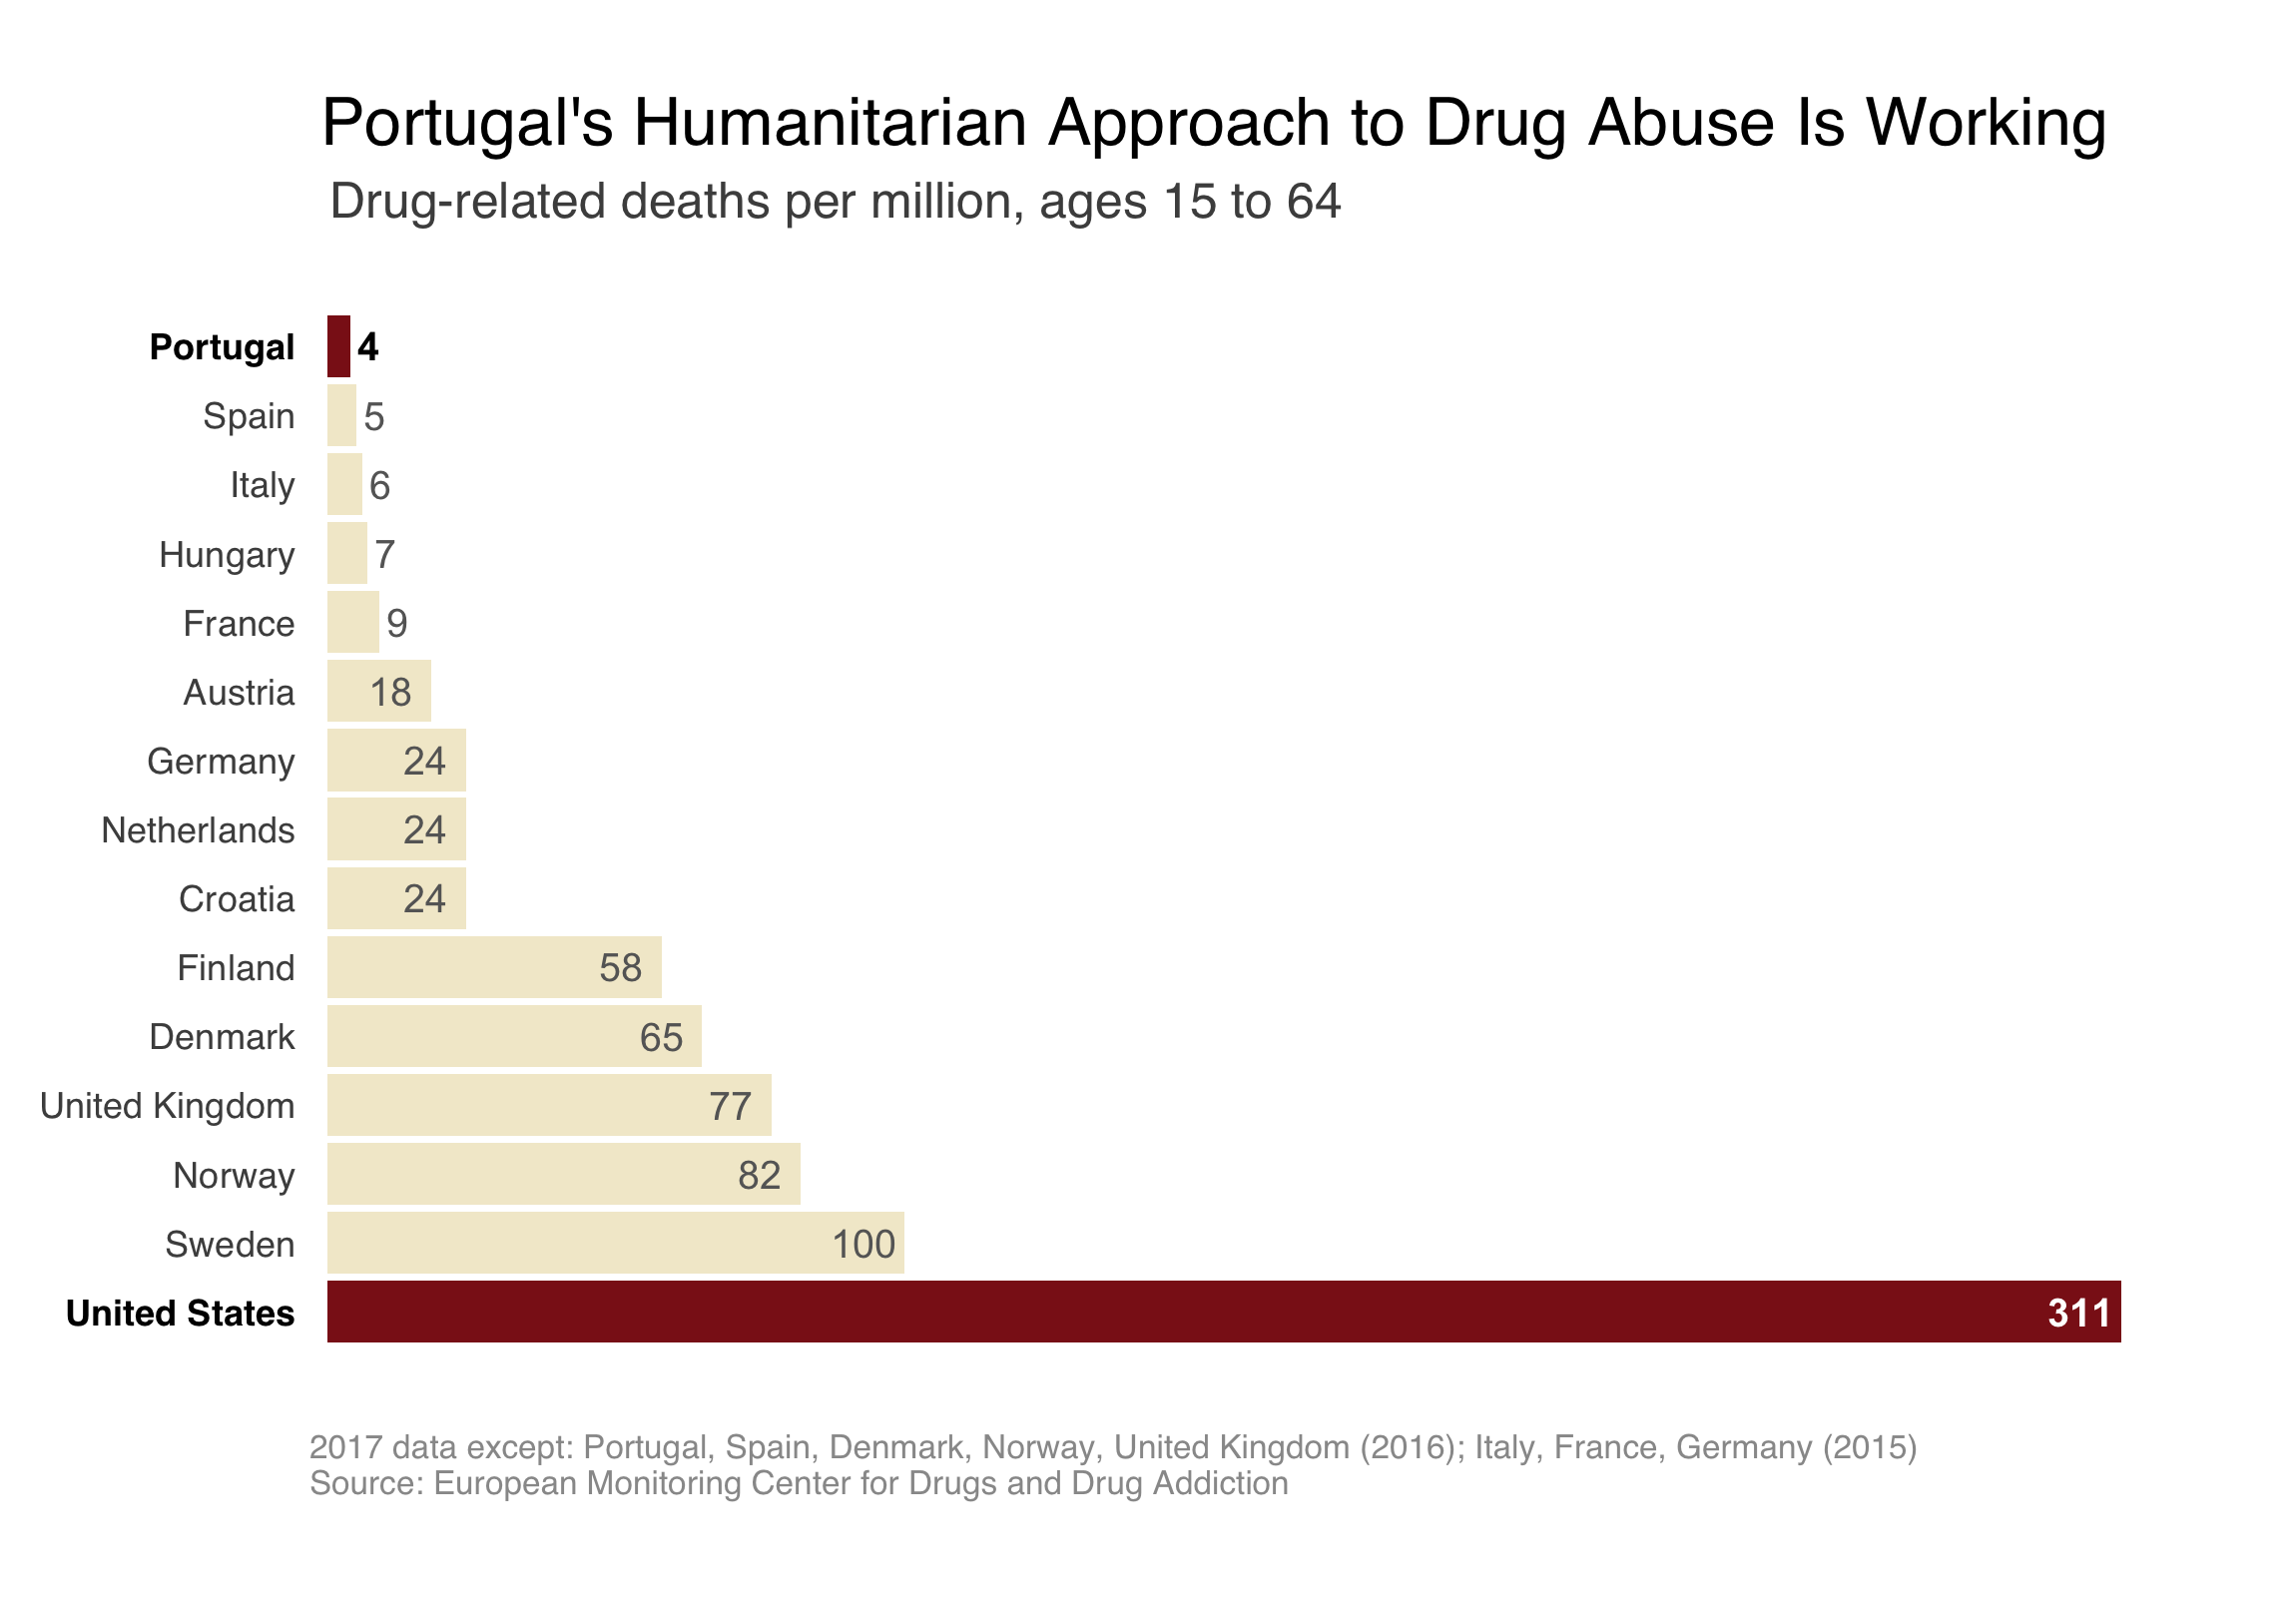

In [25]:
%%R -h 8 -w 11.5 -u in -r 200

q + ggsave('../output/portugal.png', device = 'png')